In this notebook we run training where the underlying X1 and X2 have similar dynamics (low frequency). this is done by setting c=1 and b=1. So we can avoid having a high frequency oscillations in X2 that are not being well predicted by the model. 

### imports and setup

In [1]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

In [2]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
from utils.hyperparam_tuning import remove_bad_trials, get_best_trial_config, get_best_trial_workdir
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile


/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

### choose some good params

In [4]:
CHECKPOINT_PATH = "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/experiments/tuning"

In [5]:
# find good hyperparams from study 11
study_name = "hparam_study_11"
db_path = os.path.join(CHECKPOINT_PATH, study_name, "optuna_hparam_search.db")

study11 = optuna.create_study(
    study_name=study_name,
    storage=f'sqlite:///{db_path}', # generates a new db if it doesn't exist
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5, 
        n_warmup_steps=50,
        ), 
    load_if_exists=True, 
)

study_vis = remove_bad_trials(study11)

[I 2023-12-08 21:27:44,711] Using an existing study with name 'hparam_study_11' instead of creating a new one.
[I 2023-12-08 21:27:44,849] A new study created in RDB with name: hparam_study_11_trimmed


In [6]:
fig = optuna.visualization.plot_intermediate_values(study_vis)
fig.show()

In [7]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'dropout_rate'])
fig.show()

In [8]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'edge_mlp_1_power'])
fig.show()

In [9]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'node_mlp_1_power'])
fig.show()

In [10]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'optimizer'])

fig.show()

In [11]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['optimizer', 'activation'])
fig.show()

In [12]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['activation', 'node_mlp_1_power'])
fig.show()

In [13]:
study_vis.best_trials

[FrozenTrial(number=95, state=TrialState.COMPLETE, values=[0.3530730605125427], datetime_start=datetime.datetime(2023, 12, 3, 18, 5, 4, 531748), datetime_complete=datetime.datetime(2023, 12, 3, 18, 43, 2, 232162), params={'optimizer': 'adam', 'learning_rate': 0.0005653667812390991, 'dropout_rate': 2.339089213428472e-05, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 8, 'node_mlp_2_power': 3}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.5598573088645935, 5: 0.4628971815109253, 10: 0.42287033796310425, 15: 0.3780151307582855, 20: 0.3700704872608185, 25: 0.3694515824317932, 30: 0.36563029885292053, 35: 0.36083149909973145, 40: 0.35929110646247864, 45: 0.3584330081939697, 50: 0.359792023897171, 55: 0.359622597694397, 60: 0.3573002219200134, 65: 0.3572441637516022, 70: 0.3578166663646698, 75: 0.35736122727394104, 80: 0.3562345802783966, 85: 0.35382992029190063, 90: 0.35468554496765137, 95: 0.3554139733314514, 100: 0.35811409354209

In [14]:
def sort_func(trial):
    return trial.values[0]

sorted_trials = study_vis.get_trials()
sorted_trials.sort(reverse=True, key=sort_func)
sorted_trials

[FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.9278743863105774], datetime_start=datetime.datetime(2023, 12, 2, 0, 19, 10, 908162), datetime_complete=datetime.datetime(2023, 12, 2, 0, 34, 19, 597888), params={'optimizer': 'adam', 'learning_rate': 0.02555773611181906, 'dropout_rate': 0.5128157348552024, 'activation': 'relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 5, 'node_mlp_2_power': 2}, user_attrs={}, system_attrs={}, intermediate_values={0: 1.2636358737945557, 5: 0.928261399269104, 10: 0.9295136332511902, 15: 0.9300947785377502, 20: 0.9300990700721741, 25: 0.9278782606124878, 30: 0.9292507767677307, 35: 0.9321244359016418, 40: 0.9285480380058289, 45: 0.9286603927612305, 50: 0.9298334717750549, 55: 0.9280759692192078, 60: 0.9284443855285645, 65: 0.9349215626716614, 70: 0.9279612302780151, 75: 0.9292854070663452, 80: 0.9309890270233154, 85: 0.9318312406539917, 90: 0.9296013116836548, 95: 0.9312813878059387, 100: 0.9299619197845459, 105: 0.928401

### set up config for training

based on the best parameters from study 11, we can make a guess for what params to choose in this training. 

In [15]:
def get_data_config():
    config = ml_collections.ConfigDict()

    config.n_samples=10_000
    config.input_steps=1
    config.output_delay=8 # predict 24 hrs into the future 
    config.output_steps=4
    config.timestep_duration=3 # equivalent to 3 hours
    # note a 3 hour timestep resolution would be 5*24/3=40
    # if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
    config.sample_buffer = -1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
        # number of timesteps strictly between the end 
        # of one full sample and the start of the next sample
    config.time_resolution=120 # the number of 
                # raw data points generated per time unit, equivalent to the 
                # number of data points generated per 5 days in the simulation
    config.init_buffer_samples=100
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=1
    config.b=1
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=False

    return config

In [23]:
# create config 
config = get_data_config()
config.max_checkpts_to_keep = None # None means keep all

# Optimizer.
config.optimizer = "adam"
config.learning_rate = 0.0008

# Data params that are used in training 
config.output_steps = 4

# Training hyperparameters.
config.batch_size = 1 # variable currently not used
config.epochs = 200
config.log_every_epochs = 5
config.eval_every_epochs = 5
config.checkpoint_every_epochs = 10

# GNN hyperparameters.
config.model = 'MLPBlock'
config.dropout_rate = 2e-5
config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
config.layer_norm = False # TODO perhaps we want to turn on later
config.activation = "leaky_relu"

config.pred_x1 = True
config.pred_x2 = True

if config.pred_x1 and config.pred_x2:
    output_layer = 2
else:
    output_layer = 1

# choose the hidden layer feature size using powers of 2 
config.edge_features = (
    2**2,
    2**2,
)
config.node_features = (
    2**8,
    2**3,
    output_layer,
)
# note the last feature size will be the number of features that the graph predicts
config.global_features = None



In [17]:
# generate dataset 
datasets = create_dataset(config)
print_graph_fts(datasets['train']['inputs'][0][0])

[0.00000000e+00 8.33333333e-03 1.66666667e-02 ... 2.52758333e+02
 2.52766667e+02 2.52775000e+02]
Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


### run training

In [18]:
logger.setLevel(logging.INFO)

In [24]:
# generate a workdir 
workdir="experiments/outputs/X1_X2_similar_dynamics"
# workdir = tempfile.mkdtemp()

# run training 
state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets)



INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'leaky_relu', 'b': 1, 'batch_size': 1, 'c': 1, 'checkpoint_every_epochs': 10, 'dropout_rate': 2e-05, 'edge_features': (4, 4), 'epochs': 200, 'eval_every_epochs': 5, 'fully_connected_edges': False, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.0008, 'log_every_epochs': 5, 'max_checkpts_to_keep': None, 'model': 'MLPBlock', 'n_samples': 10000, 'node_features': (256, 8, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 8, 'output_steps': 4, 'pred_x1': True, 'pred_x2': True, 'sample_buffer': -12, 'seed': 42, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+-----------------------------+-----------+-------+----------+-------+
| Name                        | Shape     | Size  | Mean     | Std   |
+-----------------------------+-------

KeyboardInterrupt: 

interrupted training so we can look at some plots

### visualize predictions

INFO:root:Initializing network.
INFO:absl:
+-----------------------------+-----------+-------+----------+-------+
| Name                        | Shape     | Size  | Mean     | Std   |
+-----------------------------+-----------+-------+----------+-------+
| params/MLP_0/Dense_0/bias   | (4,)      | 4     | 0.0      | 0.0   |
| params/MLP_0/Dense_0/kernel | (6, 4)    | 24    | -0.058   | 0.351 |
| params/MLP_0/Dense_1/bias   | (4,)      | 4     | 0.0      | 0.0   |
| params/MLP_0/Dense_1/kernel | (4, 4)    | 16    | 0.0556   | 0.457 |
| params/MLP_1/Dense_0/bias   | (256,)    | 256   | 0.0      | 0.0   |
| params/MLP_1/Dense_0/kernel | (11, 256) | 2,816 | -0.00268 | 0.313 |
| params/MLP_1/Dense_1/bias   | (8,)      | 8     | 0.0      | 0.0   |
| params/MLP_1/Dense_1/kernel | (256, 8)  | 2,048 | 0.00112  | 0.063 |
| params/MLP_1/Dense_2/bias   | (2,)      | 2     | 0.0      | 0.0   |
| params/MLP_1/Dense_2/kernel | (8, 2)    | 16    | -0.277   | 0.26  |
+-----------------------------+---

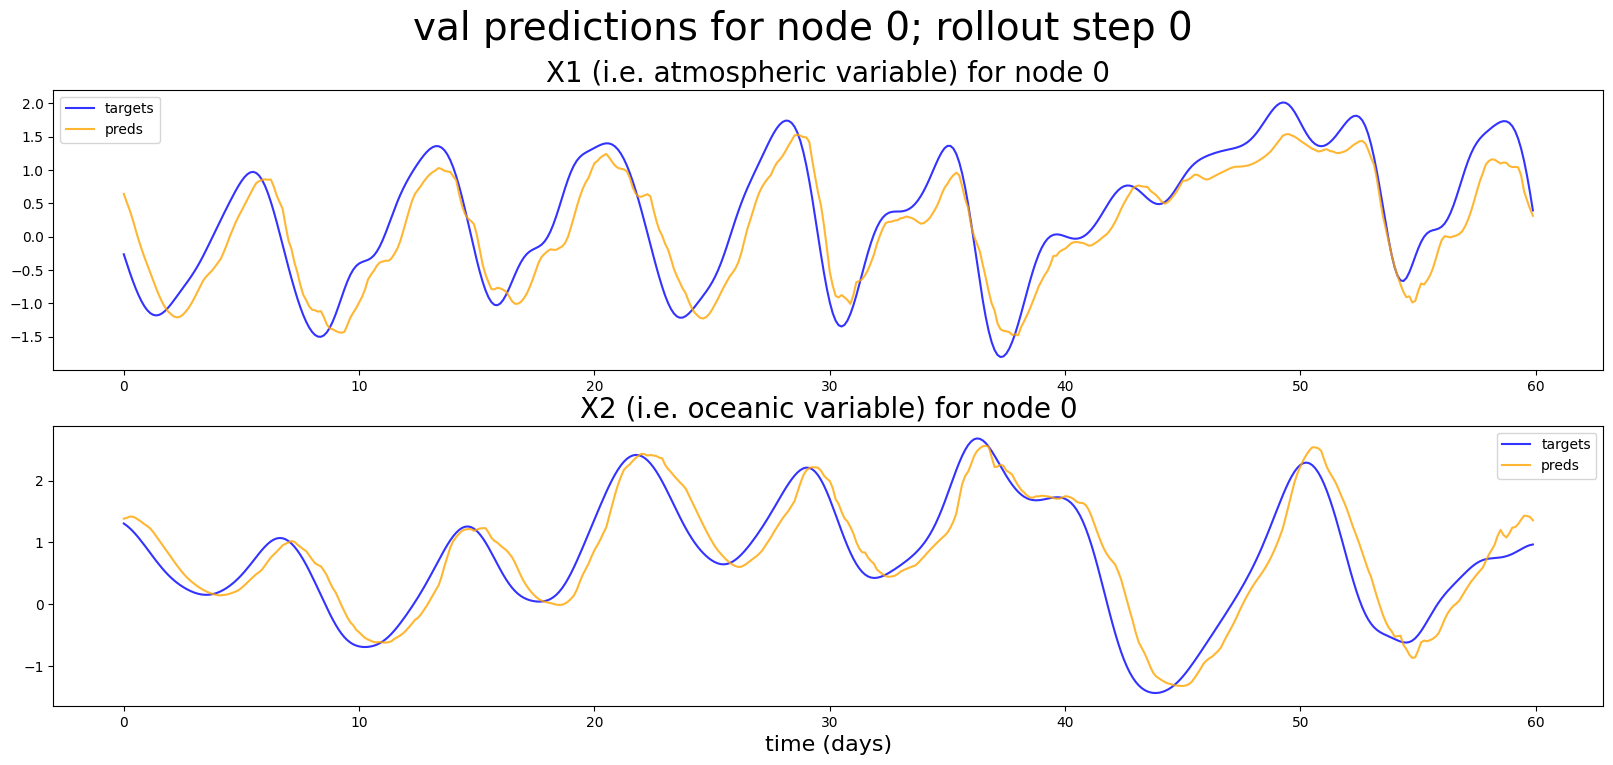

In [30]:
plot_predictions(
    config=config,
    workdir=workdir,
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_days=60, 
)

INFO:root:Initializing network.
INFO:absl:
+-----------------------------+-----------+-------+----------+-------+
| Name                        | Shape     | Size  | Mean     | Std   |
+-----------------------------+-----------+-------+----------+-------+
| params/MLP_0/Dense_0/bias   | (4,)      | 4     | 0.0      | 0.0   |
| params/MLP_0/Dense_0/kernel | (6, 4)    | 24    | -0.058   | 0.351 |
| params/MLP_0/Dense_1/bias   | (4,)      | 4     | 0.0      | 0.0   |
| params/MLP_0/Dense_1/kernel | (4, 4)    | 16    | 0.0556   | 0.457 |
| params/MLP_1/Dense_0/bias   | (256,)    | 256   | 0.0      | 0.0   |
| params/MLP_1/Dense_0/kernel | (11, 256) | 2,816 | -0.00268 | 0.313 |
| params/MLP_1/Dense_1/bias   | (8,)      | 8     | 0.0      | 0.0   |
| params/MLP_1/Dense_1/kernel | (256, 8)  | 2,048 | 0.00112  | 0.063 |
| params/MLP_1/Dense_2/bias   | (2,)      | 2     | 0.0      | 0.0   |
| params/MLP_1/Dense_2/kernel | (8, 2)    | 16    | -0.277   | 0.26  |
+-----------------------------+---

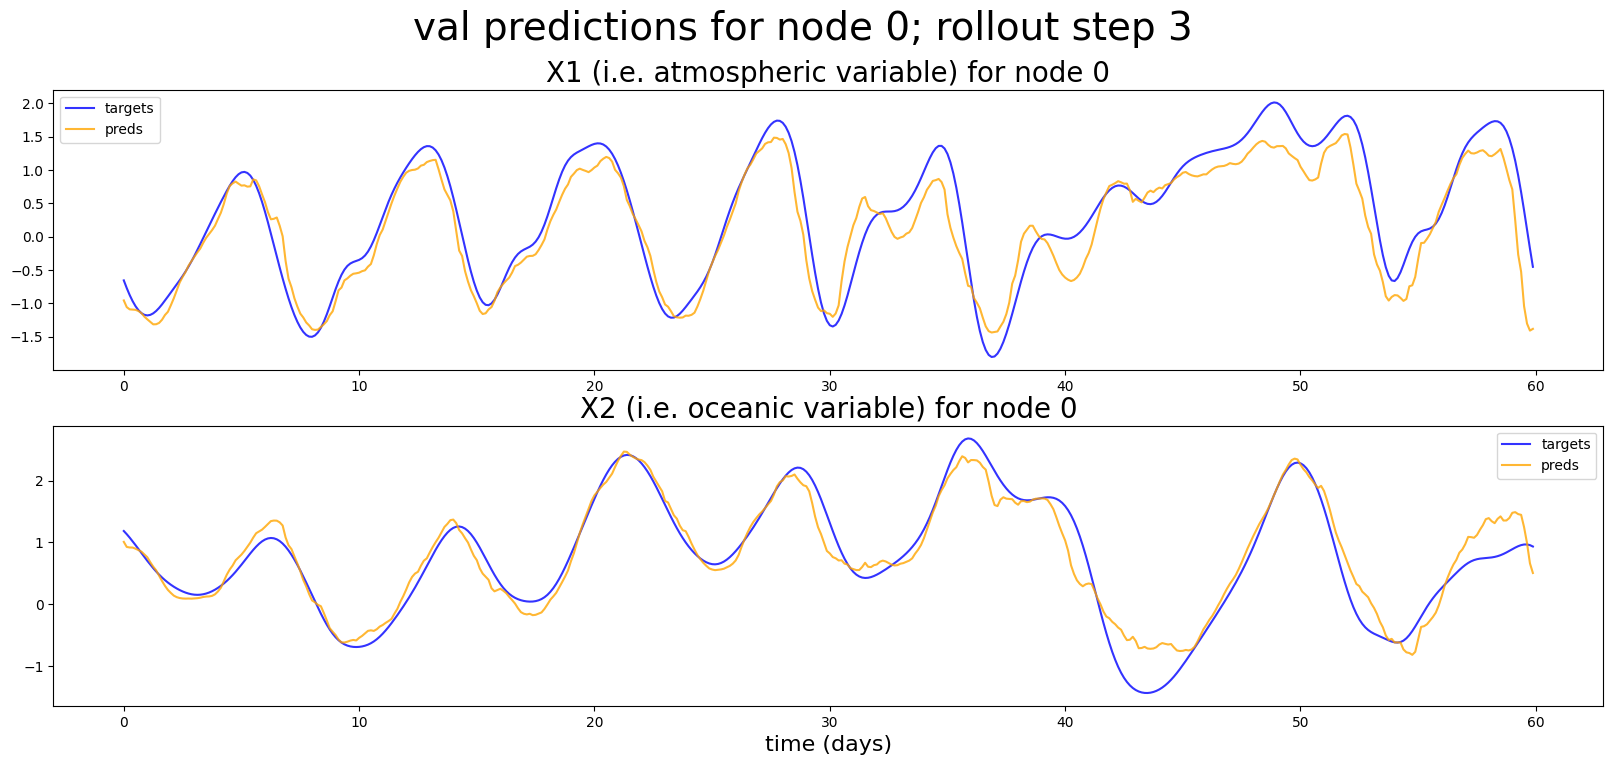

In [31]:
plot_predictions(
    config=config,
    workdir=workdir,
    plot_ith_rollout_step=3, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_days=60,
)

resume training

In [32]:
state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'activation': 'leaky_relu', 'b': 1, 'batch_size': 1, 'c': 1, 'checkpoint_every_epochs': 10, 'dropout_rate': 2e-05, 'edge_features': (4, 4), 'epochs': 200, 'eval_every_epochs': 5, 'fully_connected_edges': False, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.0008, 'log_every_epochs': 5, 'max_checkpts_to_keep': None, 'model': 'MLPBlock', 'n_samples': 10000, 'node_features': (256, 8, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 8, 'output_steps': 4, 'pred_x1': True, 'pred_x2': True, 'sample_buffer': -12, 'seed': 42, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Initializing network.
INFO:absl:
+-----------------------------+-----------+-------+----------+-------+
| Name                        | Shape     | Size  | Mean     | Std   |
+-----------------------------+-------

KeyboardInterrupt: 

wow. weird that all the losses randomly spike? even the training loss

INFO:absl:[777000] train_loss=645753.9375

let's just kill it now. 

### load best checkpoint and evaluate metrics